# Import Libraries

In [3]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split


# Load the Data

In [4]:
# Load the data
df = pd.read_csv("cleaned_coursera_dataset.csv")

In [5]:
df

,Course Title,Rating,Provider,Level,Reviews,Type,Duration / Weeks
0,Google Data Analytics,4.8,Google,Beginner,151000.0,Professional Certificate,12 - 24
1,Google Cybersecurity,4.8,Google,Beginner,35000.0,Professional Certificate,12 - 24
2,Google Project Management:,4.8,Google,Beginner,112000.0,Professional Certificate,12 - 24
3,Google Digital Marketing & E-commerce,4.8,Google,Beginner,30000.0,Professional Certificate,12 - 24
4,Google UX Design,4.8,Google,Beginner,83000.0,Professional Certificate,12 - 24
...,...,...,...,...,...,...,...
4299,Fundamentals of Machine Learning for Supply Chain,3.9,LearnQuest,Beginner,32.0,Course,1 - 4
4300,Generative Design for Industrial Applications,4.8,Autodesk,Intermediate,88.0,Course,1 - 4
4301,Social Media and Social Content Strategy,4.4,Digital Marketing Institute,Beginner,62.0,Course,1 - 4
4302,Iteration Planning and PI in Scaled Agile Fram...,3.5,Board Infinity,Intermediate,6.0,Course,1 - 4


In [6]:
df.drop('Course Title', axis=1, inplace=True)

In [7]:
df.rename(columns={'Duration / Weeks': 'Duration_Weeks'}, inplace=True)

In [8]:
df.head()

,Rating,Provider,Level,Reviews,Type,Duration_Weeks
0,4.8,Google,Beginner,151000.0,Professional Certificate,12 - 24
1,4.8,Google,Beginner,35000.0,Professional Certificate,12 - 24
2,4.8,Google,Beginner,112000.0,Professional Certificate,12 - 24
3,4.8,Google,Beginner,30000.0,Professional Certificate,12 - 24
4,4.8,Google,Beginner,83000.0,Professional Certificate,12 - 24


# Aggregat
Aggregating categorical feature

In [9]:
categorical_features = df.select_dtypes(include=['object']).columns
categorical_features

Index(['Provider', 'Level', 'Type', 'Duration_Weeks'], dtype='object')

#  One hot encoding

In [10]:
# One hot encoding
categorical_features = df.select_dtypes(include=['object']).columns
df_train = df.copy()

In [11]:
encoder = LabelEncoder()

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Apply Label Encoding on each categorical feature
for col in categorical_features:
    df_train[col] = label_encoder.fit_transform(df_train[col])

In [12]:
categorical_features

Index(['Provider', 'Level', 'Type', 'Duration_Weeks'], dtype='object')

In [13]:
df_train.shape

(4304, 6)

In [14]:
df_train

,Rating,Provider,Level,Reviews,Type,Duration_Weeks
0,4.8,65,1,151000.0,1,1
1,4.8,65,1,35000.0,1,1
2,4.8,65,1,112000.0,1,1
3,4.8,65,1,30000.0,1,1
4,4.8,65,1,83000.0,1,1
...,...,...,...,...,...,...
4299,3.9,109,1,32.0,0,0
4300,4.8,10,2,88.0,0,0
4301,4.4,44,1,62.0,0,0
4302,3.5,18,2,6.0,0,0


# Split the Rating to 5 categories by quantile

In [15]:
# Split the Rating to 5 categories by percentiles
p20 = df_train['Rating'].quantile(0.20)
p40 = df_train['Rating'].quantile(0.40)
p60 = df_train['Rating'].quantile(0.60)
p80 = df_train['Rating'].quantile(0.80)

def categorize_Rating(Rating):
    if Rating < p20:
        return 'Very low rating'
    elif Rating < p40:
        return 'Low rating'
    if Rating < p60:
        return 'Average rating'
    elif Rating < p80:
        return 'Above average rating'
    else:
        return 'Excellent rating'

df_train['categorize_Rating'] = df_train['Rating'].apply(categorize_Rating)
df_train.drop('Rating', axis=1, inplace=True)

# encoder

# Feature selection
- Step 1 : Calculate Correlation Matrix
- Step 2 : Set Correlation Threshold
- Step 3 : Select Features Based on Correlation

In [16]:
# Feature selection based on correlation
correlation = df_train.corr(numeric_only=True)
print(correlation['Duration_Weeks'].sort_values(ascending=False))


Duration_Weeks    1.000000
Type              0.076099
Level             0.048505
Provider          0.047308
Reviews           0.005513
Name: Duration_Weeks, dtype: float64


In [17]:
threshold = 0.04
selected_features = correlation[abs(correlation['Duration_Weeks']) > \
threshold]['Duration_Weeks'].index
selected_features

Index(['Provider', 'Level', 'Type', 'Duration_Weeks'], dtype='object')

In [18]:
df_train[selected_features].dtypes

Provider          int32
Level             int32
Type              int32
Duration_Weeks    int32
dtype: object

# Data Scaling
- Selecting relevant features.
- Separating the target variable.
- Standardizing the feature values to have a mean of 0 and a standard deviation of 1.

In [19]:
X = df_train[selected_features]

In [20]:
wcss = []
for i in range(2, 20):  
    kmeans = KMeans(n_clusters=i,
                    init='k-means++',
                    max_iter=300,
                    n_init=10,
                    random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

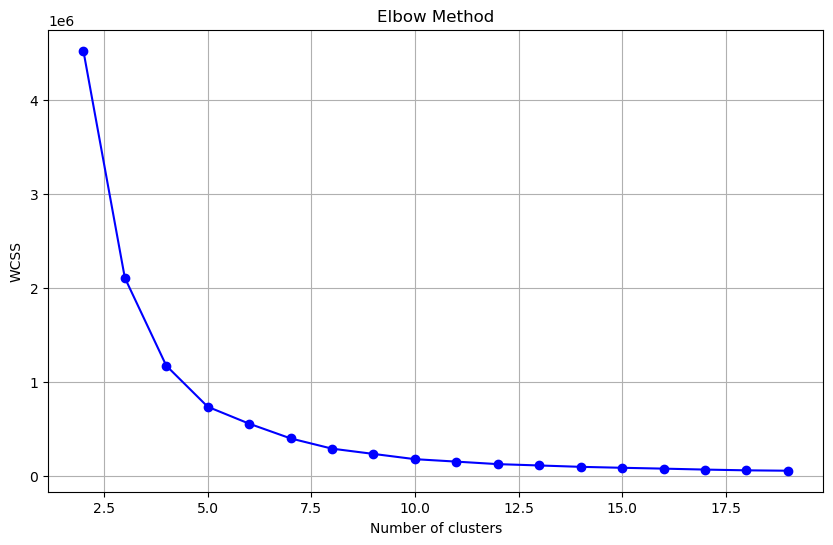

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(range(2, 20), wcss,  marker='o', linestyle='-', color='b')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

# Building and Training the model

In [22]:
# Building the KMeans Model
from sklearn.metrics import silhouette_score, make_scorer
optimal_clusters = 5

# Initialize and train the KMeans model
best_kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
x_kmeans = best_kmeans.fit_predict(X)

# Get the cluster labels
labels = best_kmeans.labels_

# Calculate the silhouette score
silhouette_avg = silhouette_score(X, x_kmeans)

print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.6438011844590494


# evaluate model

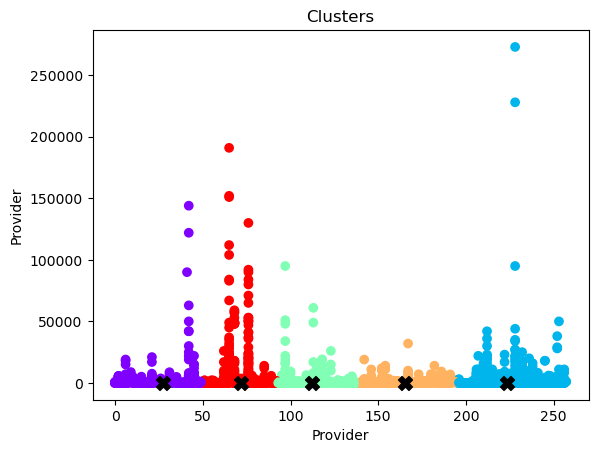

In [23]:
# plotting the clusters
plt.scatter(df_train['Provider'], df_train['Reviews'], c=x_kmeans, cmap='rainbow')
plt.scatter(best_kmeans.cluster_centers_[:, 0], best_kmeans.cluster_centers_[:, 1], s=100, c='black', marker='X')
plt.title('Clusters')
plt.xlabel('Provider')
plt.ylabel('Provider')
plt.show() 

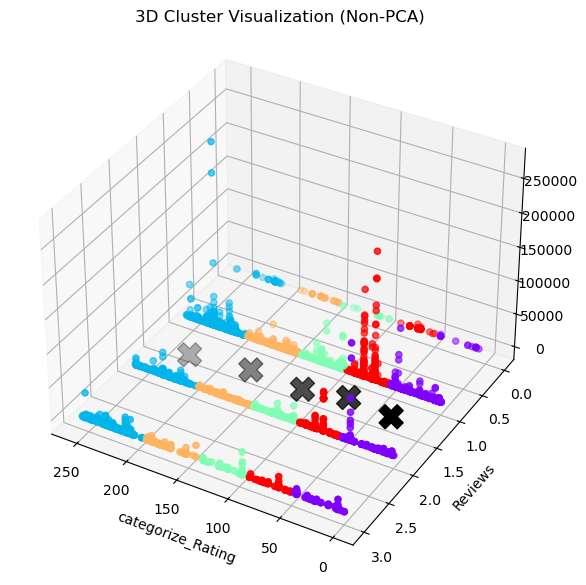

In [24]:
# Assuming 'X' has three features
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with the three features and cluster assignments
ax.scatter(df_train['Provider'], df_train['Level'], df_train['Reviews'], c=x_kmeans, cmap='rainbow', marker='o')

# Plot the cluster centers
ax.scatter(best_kmeans.cluster_centers_[:, 0], best_kmeans.cluster_centers_[:, 1], best_kmeans.cluster_centers_[:, 2], s=300, c='black', marker='X')

# Labels and title
ax.view_init(elev=35, azim=120)
ax.set_xlabel('categorize_Rating')
ax.set_ylabel('Reviews')
ax.set_zlabel('Duration / Weeks_12 - 24', labelpad=20)
ax.set_title('3D Cluster Visualization (Non-PCA)')
plt.show()

# Clusters distribution

In [25]:
clusters = kmeans.labels_


In [26]:
print(clusters)

[ 1  1  1 ...  7 15 15]


In [27]:
clusters2 = kmeans.predict(X)
print(clusters2)

[ 1  1  1 ...  7 15 15]


In [28]:
df_train['Cluster'] = kmeans.labels_

In [29]:
from sklearn.preprocessing import LabelEncoder

df_final = df.copy()

le = LabelEncoder()


for column in df_final.select_dtypes(include=['object']).columns:
    df_final[column] = le.fit_transform(df_final[column])

df_final['Cluster'] = df_train['Cluster']

In [30]:
df_final

,Rating,Provider,Level,Reviews,Type,Duration_Weeks,Cluster
0,4.8,65,1,151000.0,1,1,1
1,4.8,65,1,35000.0,1,1,1
2,4.8,65,1,112000.0,1,1,1
3,4.8,65,1,30000.0,1,1,1
4,4.8,65,1,83000.0,1,1,1
...,...,...,...,...,...,...,...
4299,3.9,109,1,32.0,0,0,5
4300,4.8,10,2,88.0,0,0,3
4301,4.4,44,1,62.0,0,0,7
4302,3.5,18,2,6.0,0,0,15


In [31]:
grouped_df = df_final.groupby('Cluster')

In [32]:
grouped_df

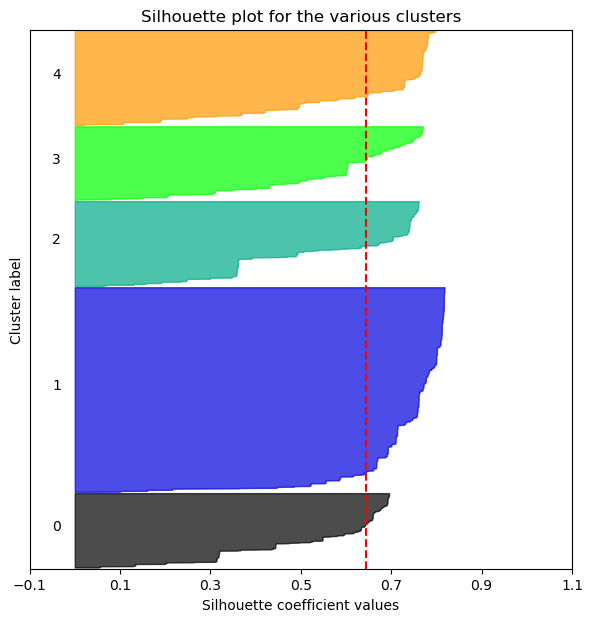

In [33]:

from sklearn.metrics import silhouette_samples, silhouette_score


sample_silhouette_values = silhouette_samples(X, labels)

y_lower = 10
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(7, 7)

ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(X) + (optimal_clusters + 1) * 10])

for i in range(optimal_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
    ith_cluster_silhouette_values.sort()
    
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = plt.cm.nipy_spectral(float(i) / optimal_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
    y_lower = y_upper + 10

ax1.set_title("Silhouette plot for the various clusters")
ax1.set_xlabel("Silhouette coefficient values")
ax1.set_ylabel("Cluster label")

ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks(np.arange(-0.1, 1.1, 0.2))

plt.show()


In [34]:
df

,Rating,Provider,Level,Reviews,Type,Duration_Weeks
0,4.8,Google,Beginner,151000.0,Professional Certificate,12 - 24
1,4.8,Google,Beginner,35000.0,Professional Certificate,12 - 24
2,4.8,Google,Beginner,112000.0,Professional Certificate,12 - 24
3,4.8,Google,Beginner,30000.0,Professional Certificate,12 - 24
4,4.8,Google,Beginner,83000.0,Professional Certificate,12 - 24
...,...,...,...,...,...,...
4299,3.9,LearnQuest,Beginner,32.0,Course,1 - 4
4300,4.8,Autodesk,Intermediate,88.0,Course,1 - 4
4301,4.4,Digital Marketing Institute,Beginner,62.0,Course,1 - 4
4302,3.5,Board Infinity,Intermediate,6.0,Course,1 - 4


In [35]:
df_final_copy = df

In [36]:
df_final_copy

,Rating,Provider,Level,Reviews,Type,Duration_Weeks
0,4.8,Google,Beginner,151000.0,Professional Certificate,12 - 24
1,4.8,Google,Beginner,35000.0,Professional Certificate,12 - 24
2,4.8,Google,Beginner,112000.0,Professional Certificate,12 - 24
3,4.8,Google,Beginner,30000.0,Professional Certificate,12 - 24
4,4.8,Google,Beginner,83000.0,Professional Certificate,12 - 24
...,...,...,...,...,...,...
4299,3.9,LearnQuest,Beginner,32.0,Course,1 - 4
4300,4.8,Autodesk,Intermediate,88.0,Course,1 - 4
4301,4.4,Digital Marketing Institute,Beginner,62.0,Course,1 - 4
4302,3.5,Board Infinity,Intermediate,6.0,Course,1 - 4


In [37]:
df_final_copy['Cluster'] = df_train['Cluster']

In [38]:
df_final_copy

,Rating,Provider,Level,Reviews,Type,Duration_Weeks,Cluster
0,4.8,Google,Beginner,151000.0,Professional Certificate,12 - 24,1
1,4.8,Google,Beginner,35000.0,Professional Certificate,12 - 24,1
2,4.8,Google,Beginner,112000.0,Professional Certificate,12 - 24,1
3,4.8,Google,Beginner,30000.0,Professional Certificate,12 - 24,1
4,4.8,Google,Beginner,83000.0,Professional Certificate,12 - 24,1
...,...,...,...,...,...,...,...
4299,3.9,LearnQuest,Beginner,32.0,Course,1 - 4,5
4300,4.8,Autodesk,Intermediate,88.0,Course,1 - 4,3
4301,4.4,Digital Marketing Institute,Beginner,62.0,Course,1 - 4,7
4302,3.5,Board Infinity,Intermediate,6.0,Course,1 - 4,15


In [39]:
df

,Rating,Provider,Level,Reviews,Type,Duration_Weeks,Cluster
0,4.8,Google,Beginner,151000.0,Professional Certificate,12 - 24,1
1,4.8,Google,Beginner,35000.0,Professional Certificate,12 - 24,1
2,4.8,Google,Beginner,112000.0,Professional Certificate,12 - 24,1
3,4.8,Google,Beginner,30000.0,Professional Certificate,12 - 24,1
4,4.8,Google,Beginner,83000.0,Professional Certificate,12 - 24,1
...,...,...,...,...,...,...,...
4299,3.9,LearnQuest,Beginner,32.0,Course,1 - 4,5
4300,4.8,Autodesk,Intermediate,88.0,Course,1 - 4,3
4301,4.4,Digital Marketing Institute,Beginner,62.0,Course,1 - 4,7
4302,3.5,Board Infinity,Intermediate,6.0,Course,1 - 4,15


In [40]:
unique_values_list = df_train['categorize_Rating'].unique().tolist()
print(unique_values_list)

['Excellent rating', 'Average rating', 'Above average rating', 'Low rating', 'Very low rating']


In [41]:
import joblib
joblib.dump(best_kmeans, 'kmens_model.joblib')
joblib.dump(label_encoder, 'kmens_scaler.joblib')

['kmens_scaler.joblib']